z resolution is 0.01000


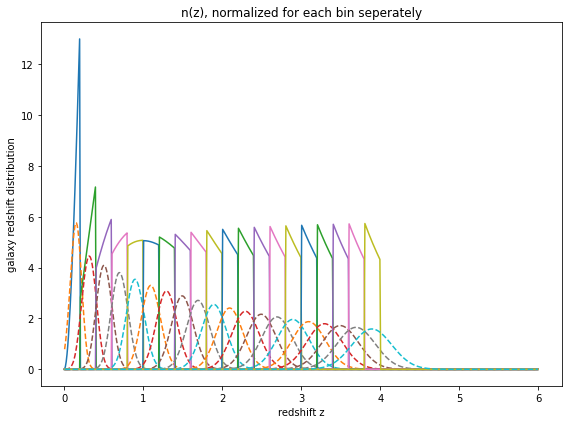

In [1]:
import os,sys,inspect
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.integrate as intg

#import modules from parent directory
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
from interpolation_fncs import *
from io_fncs import *
from gal_distr import *

#io
outputparentfolder = '/Users/junzhezhou/Desktop/Cosmology Indep Study/IA-Self-Calib-Data/'
outputfolder       = 'run0'
outputpath         = os.path.join(outputparentfolder, outputfolder)
create_dir(outputpath)

#constants
Omega0 = 0.3 #present day matter density in unit of critical density
OmegaLambda = 0.7
Omegak = 1-Omega0-OmegaLambda
deltaz = 0.2 #redshift bin width
#in integration 1 redshift is broken into z_res intervals
#for z_max = 4, zres = 400 ~20sec/run
z_bin_num = 20
z_max = z_bin_num*deltaz+2 #+2 redshift reserved for photometric error
z_res = 100 

save_config_file(os.path.join(outputpath,'values.txt'),
                 ['Identifier',outputfolder,
                  'Omega0',Omega0,
                  'OmegaLambda',OmegaLambda,
                  'Omegak',Omegak,
                  'deltaz',deltaz,
                  'z_bin_num',z_bin_num,
                  'z_max',z_max,
                  'z_res',z_res,
                  'z_res_spacing',1/z_res])

print('z resolution is %1.5f' %(1/z_res))

get_gal_distr(z_bin_num,deltaz,z_res,'z2exp_gausPDF',outputpath,False)



In [6]:
#Input matter density spectrum Del_mg[l,z]
Del_l_list = np.logspace(2,4,num=20) #log scale from 10^2 to 10^4
#Del_z_list should be set to = z_list
#throw away the first element to perform right Riemann sum to avoid 0 division
z_list = np.linspace(0,z_max,z_max*z_res,dtype='float64')[1:]
Del_mg = np.ones((len(Del_l_list),len(z_list)))

#comoving distance function, in unit of c/H0
#Troxel and Ishak 2014 equation (8) without the factor of H0
chi_list = np.array([],dtype='float64')
def chi_integrand(z):
    return 1/np.sqrt(Omega0*(1+z)**3+Omegak*(1+z)**2+OmegaLambda)
def chi(z):
    return intg.quad(chi_integrand,0,z)[0]
for z in z_list: chi_list = np.append(chi_list,chi(z))
# plt.plot(z_list, chi_list)
# plt.xlabel('redshift z')
# plt.ylabel('comoving distance chi(z) \n Omega0=%1.2f, OmegaLambda=%1.2f' %(Omega0,OmegaLambda))
# plt.show()

# Lensing Kernel List
# W_L_list[z_list,z_list]
W_L_list = np.empty((len(z_list),len(z_list)),dtype='float64')
for z_G_index in range(len(z_list)):
    chi_G = chi_list[z_G_index]
    W_L_list[z_G_index] = 1.5*Omega0*(1+z_list)*chi_list*(1-chi_list/chi_G)
W_L_list[W_L_list<0]=0 #set negative entries to 0 (eqv. set chi_L>chi_G entries to 0)
# test = W_L_list.clip(min=0) This is slightly slower than the above method
# test_redshift_index = int(1.2*z_res)
# plt.plot(z_list, W_L_list[test_redshift_index])
# plt.xlabel('redshift z')
# plt.ylabel('lensing kernel W_L with source z_G=%1.4f' %(z_list[test_redshift_index]))
# plt.show()

def get_Q_function(i,Del_mg,Del_l_list,z_list):
    "get the Q function for the ith redshift bin. (i>=0)"

    ################################################
    #get the Q fnc for a single redshift bin
    ################################################
    z_i_center = deltaz*(i+0.5) #the center for the ith redshift bin
    z_lowerbound = z_i_center-deltaz/2
    z_upperbound = z_i_center+deltaz/2
    #i = 1 -> 0-0.2
    #i = 3 -> 0.4-0.6
    #i = 6 -> 1.0-1.2
    #i = 9 -> 1.8-2.0
    
    print("calculating for redshift bin %1.2f - %1.2f" %(z_lowerbound,z_upperbound))

    ################################################
    #Setups - Calculating related functions
    ################################################

    #Redshift coordinates
    #throw away the first element to perform right Riemann sum to avoid 0 division
    z_i_list = np.linspace(z_lowerbound,z_upperbound,int(deltaz*z_res),dtype='float64')[1:]

    #Gaussian Photo-Z PDF bin i
    photozPDF = np.empty((len(z_list),len(z_i_list)),dtype='float64')
    for ztrue_index in range(len(z_list)):
        ztrue = z_list[ztrue_index]
        #std function as a linear in redshift
        #Zhang 2010 discusses when 0.05->0.03 accuracy improves by 2.3x on page 7 bottom right
        std = gaussian_spread*(1+ztrue)
        #gaussian pdf
        prefector = 1/(np.sqrt(2*np.pi)*std)
        photozPDF[ztrue_index] = prefector*np.exp(-0.5*((z_i_list-ztrue)/std)**2)
#     test_redshift_index=int(1.25*z_res)
#     plt.plot(z_i_list, photozPDF[test_redshift_index],label='area under the curve=%1.3f'%(sum(photozPDF[test_redshift_index]/z_res)))
#     plt.xlabel('redshift z')
#     plt.ylabel('photo_z PDF around z_true=%1.4f, \n with sigma_p=%1.3f' %(z_list[test_redshift_index],gaussian_spread))
#     plt.show()

    #galaxy photo z distribution
    def n(z):
        return z*z*np.exp(-z/0.5)

    #galaxy photo z distribution normalized in bin i
    n_photo_i_norm = intg.quad(n,z_lowerbound,z_upperbound)[0]
    def n_photo_i(z):
        return z*z*np.exp(-z/0.5)/n_photo_i_norm
    n_photo_i_list = n_photo_i(z_i_list)

    #galaxy photo z distribution normalized from 0 to infinity=z_max
    n_photo_all_norm = intg.quad(n,0,z_max)[0]
    def n_photo_all(z):
        return z*z*np.exp(-z/0.5)/n_photo_all_norm
    n_photo_all_list = n_photo_all(z_list)

    #galaxy true z distribution (photo z distribution + smear) normalized from 0 to infinity=z_max
    n_i_list = np.zeros(len(z_list))
    z_i_list_index = 0
    for ztrue in z_i_list:
        std = gaussian_spread*(1+ztrue)
        prefector = 1/(np.sqrt(2*np.pi)*std)
        n_i_list += n_photo_i_list[z_i_list_index]*prefector*np.exp(-0.5*((z_list-ztrue)/std)**2)
        z_i_list_index += 1
    n_i_list_norm = sum(n_i_list)/z_res
    n_i_list = n_i_list/n_i_list_norm

    #galaxy true z distribution (photo z distribution + smear) normalized in bin i
    n_i_bin_list = np.zeros(len(z_i_list))
    z_i_list_index = 0
    for ztrue in z_i_list:
        std = gaussian_spread*(1+ztrue)
        prefector = 1/(np.sqrt(2*np.pi)*std)
        n_i_bin_list += n_photo_i_list[z_i_list_index]*prefector*np.exp(-0.5*((z_i_list-ztrue)/std)**2)
        z_i_list_index += 1
    n_i_bin_list_norm = sum(n_i_bin_list)/z_res
    n_i_bin_list = n_i_bin_list/n_i_bin_list_norm

#     plt.plot(z_list, n_photo_all_list,linestyle='dashed',label = 'n_photo_all_list (photoz) normalized from z=0 to z=inf=z_max')
#     plt.plot(z_list, n_i_list,label = 'n_i_list (truez) normalized from z=0 to z=inf=z_max')
#     plt.plot(z_i_list, n_photo_i_list,linestyle='dashed',label = 'n_z_i_list (photoz) truncated and normalized in the %1i th redshift bin'%i)
#     plt.plot(z_i_list, n_i_bin_list,label = 'n_i_bin_list (truez) truncated and normalized in the %1i th redshift bin'%i)
#     plt.xlabel('redshift z')
#     plt.ylabel('galaxy redshift distribution')
#     plt.legend(bbox_to_anchor=(1, 1.05))
#     plt.show()

    #Integrated kernel, Zhang 2010 (A2)
    W_i = np.empty(len(z_list))
    for z_L_index in range(len(z_list)):
        W_i[z_L_index] = sum(W_L_list[z_L_index]*n_i_list)/z_res #using the true redshift distribution
#     plt.plot(z_list, W_i)
#     plt.xlabel('redshift z')
#     plt.ylabel('W_i for the %1i th redshift bin'%i)
#     plt.show()

    ################################################
    #Main Calculation integration (Zhang 2010, Appendix B)
    ################################################

    eta = 0
    eta_z = np.empty(len(z_list),dtype='float64')
    ui = np.empty(len(z_list),dtype='float64')
    li = np.empty(len(z_list),dtype='float64')

    for z_index in range(len(z_list)):#[int(1.2*z_res)]
        ################
        #Upper integral with out multiplying the volume element (canceled out when dividing)
        #the matrix corr. to p(z,z_g^P)*n_i^P(z_G^P)*n_i^P(z_g^P)*S(z_G^P,z_g^P) #indices: (z_G^P,z_g^P)
        psnn_zGP = np.empty(len(z_i_list),dtype='float64')
        Wppsnn_2D = np.empty((len(z_list),len(z_i_list)),dtype='float64') 
        #Lower integral with out multiplying the volume element (canceled out when dividing)
        #the matrix corr. to p(z,z_g^P)*n_i^P(z_G^P)*n_i^P(z_g^P) #indices: (z_G^P,z_g^P)
        pnn_zGP = np.empty(len(z_i_list),dtype='float64')
        Wppnn_2D = np.empty((len(z_list),len(z_i_list)),dtype='float64') 

        for zGP_index in range(len(z_i_list)):
            filterfunction = z_i_list-z_i_list[zGP_index] #filterfunction has entries 0 if zgP-zGP>0
            filterfunction[filterfunction>0]=0
            filterfunction=filterfunction != 0 #False for entries zgP-zGP>0
            #sum over the zgP variable. Left with "z_res*intg_zilb^ziub (p*S*n*n)@z=z_list[z_index]""
            temp_vec = photozPDF[z_index]*n_photo_i_list[zGP_index]*n_photo_i_list
            psnn_zGP[zGP_index] = np.sum(temp_vec*filterfunction,dtype='float64')
            #sum over the zgP variable. Left with "z_res*intg_zilb^ziub (p*n*n)@z=z_list[z_index]""
            pnn_zGP[zGP_index] = np.sum(temp_vec,dtype='float64')
    #         print(np.sum(temp_vec*filterfunction),np.sum(temp_vec))
    #         print(psnn_zGP[zGP_index],pnn_zGP[zGP_index])

        #Adding the z_G variable and double summation
        for zG_index in range(len(z_list)):
            Wppsnn_2D[zG_index] = W_L_list[z_index,zG_index]*photozPDF[zG_index]*psnn_zGP
            Wppnn_2D[zG_index]  = W_L_list[z_index,zG_index]*photozPDF[zG_index]*pnn_zGP
        Wppsnn_2D_sum = 2*np.sum(Wppsnn_2D,dtype='float64')
        Wppnn_2D_sum  = np.sum(Wppnn_2D,dtype='float64') 
    #    print(Wppsnn_2D)
    #    print(Wppnn_2D_sum,Wppnn_2D_sum)
        if Wppnn_2D_sum == 0: increment = 0
        else: increment = Wppsnn_2D_sum/Wppnn_2D_sum
        #print(Wppsnn_2D_sum)
        eta += increment
        eta_z[z_index] = increment
        ui[z_index] = Wppsnn_2D_sum
        li[z_index] = Wppnn_2D_sum

#     plt.subplot(3,1,1)
#     plt.plot(z_list, ui,label='upper Wppsnn_2D_sum')
#     plt.plot(z_list, li,label='lower Wppnn_2D_sum')
#     plt.xlabel('redshift z (up till integration limit)')
#     plt.ylabel('fncs')
#     #plt.yscale('log')
#     plt.legend()
#     plt.show()

#     plt.subplot(3,1,2)
#     plt.plot(z_list, chi_list*W_i*n_i_list,label='modulation')
#     plt.xlabel('redshift z (up till integration limit)')
#     plt.ylabel('modulation on eta(z)')
#     plt.legend()
#     plt.show()

#     plt.subplot(3,1,3)
#     plt.plot(z_list, eta_z,label='area under the curve = intg(eta) = %1.2f'%(eta/z_res))
#     plt.xlabel('redshift z (up till integration limit)')
#     plt.ylabel('eta(z),%1i th redshift bin'%i)
#     plt.legend()
#     plt.show()

    #Del_l_list = np.logspace(2,4,num=20) #log scale from 10^2 to 10^4
    #Del_z_list should be set to =z_list
    #Del_mg = np.ones((len(Del_l_list),len(z_list)))
    Q_list = np.empty(len(Del_l_list))
    
    l_index = 0
    for Del_l in Del_l_list:
        #scipy.integrate.cumtrapz(y, x=None, dx=1.0, axis=-1, initial=None)
        temp_vec = Del_l*chi_list*W_i*n_i_list
        #print(temp_vec.shape,z_list.shape)
        CiiGgS=np.trapz(temp_vec*eta_z, x=z_list)
        CiiGg =np.trapz(temp_vec, x=z_list)
        Q_list[l_index] = CiiGgS/CiiGg
        l_index += 1
        
    return Q_list

z resolution is 0.00250


calculating for redshift bin 0.40 - 0.60
calculating for redshift bin 1.00 - 1.20
calculating for redshift bin 1.80 - 2.00


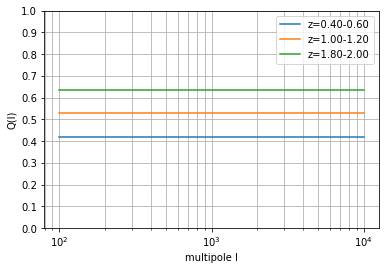

In [7]:
Q2=get_Q_function(2,Del_mg,Del_l_list,z_list)
Q5=get_Q_function(5,Del_mg,Del_l_list,z_list)
Q9=get_Q_function(9,Del_mg,Del_l_list,z_list)

plt.figure()
plt.plot(Del_l_list, Q2,label='z=%1.2f-%1.2f'%(0.4,0.6))
plt.plot(Del_l_list, Q5,label='z=%1.2f-%1.2f'%(1.0,1.2))
plt.plot(Del_l_list, Q9,label='z=%1.2f-%1.2f'%(1.8,2.0))
plt.xlabel('multipole l')
plt.xscale('log')
plt.ylabel('Q(l)')
plt.ylim(0,1)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True,axis='both',which='both')
plt.legend()
plt.show()

z resolution is 0.00250
calculating for redshift bin 0.40 - 0.60


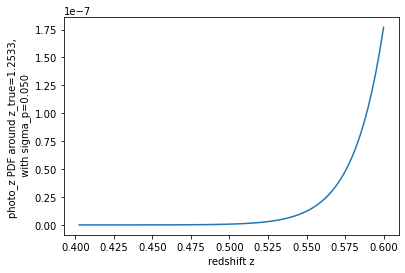

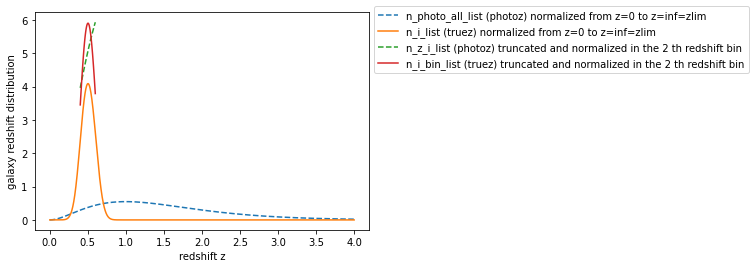

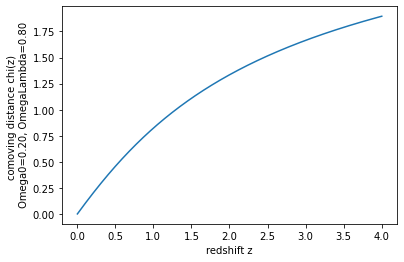

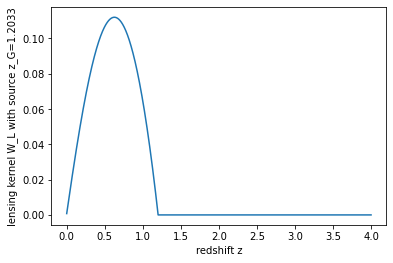

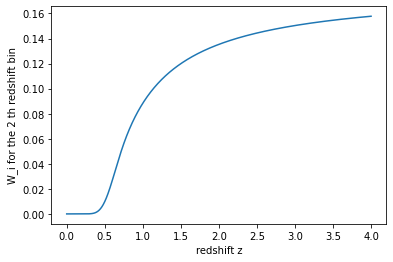

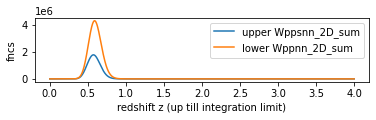

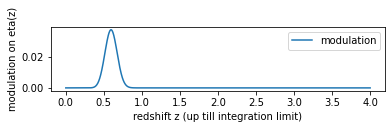

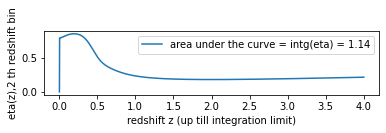

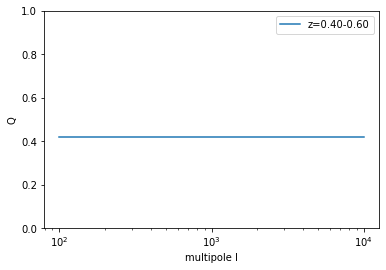

CPU times: user 18.5 s, sys: 138 ms, total: 18.6 s
Wall time: 18.8 s


In [4]:
%%time
################################################
#Demo: getting Q fnc for a single redshift bin
################################################

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.integrate as intg

#constants
Omega0 = 0.2 #present day matter density in unit of critical density
OmegaLambda = 0.8
Omegak = 1-Omega0-OmegaLambda

deltaz = 0.2 #redshift bin width
z_min = 0
z_max = 4
z_res = 400 #in integration 1 redshift is broken into z_res intervals
gaussian_spread = 0.05
print('z resolution is %1.5f' %(1/z_res))

i = 2
z_i_center = deltaz*(i+0.5) #the center for the ith redshift bin
z_lowerbound = z_i_center-deltaz/2
z_upperbound = z_i_center+deltaz/2
print("calculating for redshift bin %1.2f - %1.2f" %(z_lowerbound,z_upperbound))

################################################
#Setups - Calculating related functions
################################################

#Redshift coordinates
#throw away the first element to perform right Riemann sum to avoid 0 division
z_list = np.linspace(0,z_max,z_max*z_res,dtype='float64')[1:]
z_i_list = np.linspace(z_lowerbound,z_upperbound,int(deltaz*z_res),dtype='float64')[1:]

#Gaussian Photo-Z PDF
photozPDF = np.empty((len(z_list),len(z_i_list)),dtype='float64')
for ztrue_index in range(len(z_list)):
    ztrue = z_list[ztrue_index]
    #std function as a linear in redshift
    #Zhang 2010 discusses when 0.05->0.03 accuracy improves by 2.3x on page 7 bottom right
    std = gaussian_spread*(1+ztrue)
    #gaussian pdf
    prefector = 1/(np.sqrt(2*np.pi)*std)
    photozPDF[ztrue_index] = prefector*np.exp(-0.5*((z_i_list-ztrue)/std)**2)
test_redshift_index=int(1.25*z_res)
plt.plot(z_i_list, photozPDF[test_redshift_index],label='area under the curve=%1.3f'%(sum(photozPDF[test_redshift_index]/z_res)))
plt.xlabel('redshift z')
plt.ylabel('photo_z PDF around z_true=%1.4f, \n with sigma_p=%1.3f' %(z_list[test_redshift_index],gaussian_spread))
plt.show()

#galaxy true z distribution
def n(z):
    return z*z*np.exp(-z/0.5)

#galaxy true z distribution normalized in bin i
n_photo_i_norm = intg.quad(n,z_lowerbound,z_upperbound)[0]
def n_i(z):
    return z*z*np.exp(-z/0.5)/n_photo_i_norm
n_photo_i_list = n_i(z_i_list)

#galaxy true z distribution normalized from 0 to infinity=z_max
n_photo_all_norm = intg.quad(n,0,z_max)[0]
def n_all(z):
    return z*z*np.exp(-z/0.5)/n_photo_all_norm
n_photo_all_list = n_all(z_list)

#galaxy photo z distribution (true z distribution + smear) normalized from 0 to infinity=z_max
n_i_list = np.zeros(len(z_list))
z_i_list_index = 0
for ztrue in z_i_list:
    std = gaussian_spread*(1+ztrue)
    prefector = 1/(np.sqrt(2*np.pi)*std)
    n_i_list += n_photo_i_list[z_i_list_index]*prefector*np.exp(-0.5*((z_list-ztrue)/std)**2)
    z_i_list_index += 1
n_i_list_norm = sum(n_i_list)/z_res
n_i_list = n_i_list/n_i_list_norm

#galaxy photo z distribution (true z distribution + smear) normalized in bin i
n_i_bin_list = np.zeros(len(z_i_list))
z_i_list_index = 0
for ztrue in z_i_list:
    std = gaussian_spread*(1+ztrue)
    prefector = 1/(np.sqrt(2*np.pi)*std)
    n_i_bin_list += n_photo_i_list[z_i_list_index]*prefector*np.exp(-0.5*((z_i_list-ztrue)/std)**2)
    z_i_list_index += 1
n_i_bin_list_norm = sum(n_i_bin_list)/z_res
n_i_bin_list = n_i_bin_list/n_i_bin_list_norm

plt.plot(z_list, n_photo_all_list,linestyle='dashed',label = 'n_photo_all_list (photoz) normalized from z=0 to z=inf=z_max')
plt.plot(z_list, n_i_list,label = 'n_i_list (truez) normalized from z=0 to z=inf=z_max')
plt.plot(z_i_list, n_photo_i_list,linestyle='dashed',label = 'n_z_i_list (photoz) truncated and normalized in the %1i th redshift bin'%i)
plt.plot(z_i_list, n_i_bin_list,label = 'n_i_bin_list (truez) truncated and normalized in the %1i th redshift bin'%i)
plt.xlabel('redshift z')
plt.ylabel('galaxy redshift distribution')
plt.legend(bbox_to_anchor=(1, 1.05))
plt.show()

#comoving distance function, in unit of c/H0
#Troxel and Ishak 2014 equation (8) without the factor of H0
chi_list = np.array([],dtype='float64')
def chi_integrand(z):
    return 1/np.sqrt(Omega0*(1+z)**3+Omegak*(1+z)**2+OmegaLambda)
def chi(z):
    return intg.quad(chi_integrand,0,z)[0]
for z in z_list: chi_list = np.append(chi_list,chi(z))
plt.plot(z_list, chi_list)
plt.xlabel('redshift z')
plt.ylabel('comoving distance chi(z) \n Omega0=%1.2f, OmegaLambda=%1.2f' %(Omega0,OmegaLambda))
plt.show()

#Lensing Kernel List
#W_L_list[z_list,z_list]
W_L_list = np.empty((len(z_list),len(z_list)),dtype='float64')
for z_G_index in range(len(z_list)):
    chi_G = chi_list[z_G_index]
    W_L_list[z_G_index] = 1.5*Omega0*(1+z_list)*chi_list*(1-chi_list/chi_G)
W_L_list[W_L_list<0]=0 #set negative entries to 0 (eqv. set chi_L>chi_G entries to 0)
    #test = W_L_list.clip(min=0) This is slightly slower than the above method
test_redshift_index = int(1.2*z_res)
plt.plot(z_list, W_L_list[test_redshift_index])
plt.xlabel('redshift z')
plt.ylabel('lensing kernel W_L with source z_G=%1.4f' %(z_list[test_redshift_index]))
plt.show()

#Integrated kernel, Zhang 2010 (A2)
W_i = np.empty(len(z_list))
for z_L_index in range(len(z_list)):
    W_i[z_L_index] = sum(W_L_list[z_L_index]*n_i_list)/z_res #using the true redshift distribution
plt.plot(z_list, W_i)
plt.xlabel('redshift z')
plt.ylabel('W_i for the %1i th redshift bin'%i)
plt.show()

################################################
#Main Calculation integration (Zhang 2010, Appendix B)
################################################

eta = 0
eta_z = np.empty(len(z_list),dtype='float64')
ui = np.empty(len(z_list),dtype='float64')
li = np.empty(len(z_list),dtype='float64')

for z_index in range(len(z_list)):#[int(1.2*z_res)]
    ################
    #Upper integral with out multiplying the volume element (canceled out when dividing)
    #the matrix corr. to p(z,z_g^P)*n_i^P(z_G^P)*n_i^P(z_g^P)*S(z_G^P,z_g^P) #indices: (z_G^P,z_g^P)
    psnn_zGP = np.empty(len(z_i_list),dtype='float64')
    Wppsnn_2D = np.empty((len(z_list),len(z_i_list)),dtype='float64') 
    #Lower integral with out multiplying the volume element (canceled out when dividing)
    #the matrix corr. to p(z,z_g^P)*n_i^P(z_G^P)*n_i^P(z_g^P) #indices: (z_G^P,z_g^P)
    pnn_zGP = np.empty(len(z_i_list),dtype='float64')
    Wppnn_2D = np.empty((len(z_list),len(z_i_list)),dtype='float64') 
    
    for zGP_index in range(len(z_i_list)):
        filterfunction = z_i_list-z_i_list[zGP_index] #filterfunction has entries 0 if zgP-zGP>0
        filterfunction[filterfunction>0]=0
        filterfunction=filterfunction != 0 #False for entries zgP-zGP>0
        #sum over the zgP variable. Left with "z_res*intg_zilb^ziub (p*S*n*n)@z=z_list[z_index]""
        temp_vec = photozPDF[z_index]*n_photo_i_list[zGP_index]*n_photo_i_list
        psnn_zGP[zGP_index] = np.sum(temp_vec*filterfunction,dtype='float64')
        #sum over the zgP variable. Left with "z_res*intg_zilb^ziub (p*n*n)@z=z_list[z_index]""
        pnn_zGP[zGP_index] = np.sum(temp_vec,dtype='float64')
#         print(np.sum(temp_vec*filterfunction),np.sum(temp_vec))
#         print(psnn_zGP[zGP_index],pnn_zGP[zGP_index])
        
    #Adding the z_G variable and double summation
    for zG_index in range(len(z_list)):
        Wppsnn_2D[zG_index] = W_L_list[z_index,zG_index]*photozPDF[zG_index]*psnn_zGP
        Wppnn_2D[zG_index]  = W_L_list[z_index,zG_index]*photozPDF[zG_index]*pnn_zGP
    Wppsnn_2D_sum = 2*np.sum(Wppsnn_2D,dtype='float64')
    Wppnn_2D_sum  = np.sum(Wppnn_2D,dtype='float64') 
#    print(Wppsnn_2D)
#    print(Wppnn_2D_sum,Wppnn_2D_sum)
    if Wppnn_2D_sum == 0: increment = 0
    else: increment = Wppsnn_2D_sum/Wppnn_2D_sum
    #print(Wppsnn_2D_sum)
    eta += increment
    eta_z[z_index] = increment
    ui[z_index] = Wppsnn_2D_sum
    li[z_index] = Wppnn_2D_sum
    
plt.subplot(3,1,1)
plt.plot(z_list, ui,label='upper Wppsnn_2D_sum')
plt.plot(z_list, li,label='lower Wppnn_2D_sum')
plt.xlabel('redshift z (up till integration limit)')
plt.ylabel('fncs')
#plt.yscale('log')
plt.legend()
plt.show()

plt.subplot(3,1,2)
plt.plot(z_list, chi_list*W_i*n_i_list,label='modulation')
plt.xlabel('redshift z (up till integration limit)')
plt.ylabel('modulation on eta(z)')
plt.legend()
plt.show()

plt.subplot(3,1,3)
plt.plot(z_list, eta_z,label='area under the curve = intg(eta) = %1.2f'%(eta/z_res))
plt.xlabel('redshift z (up till integration limit)')
plt.ylabel('eta(z),%1i th redshift bin'%i)
plt.legend()
plt.show()

Del_l_list = np.logspace(2,4,num=20) #log scale from 10^2 to 10^4
#Del_z_list should be set to =z_list
Del_mg = np.ones((len(Del_l_list),len(z_list)))
Q_list = np.empty(len(Del_l_list))
l_index = 0

for Del_l in Del_l_list:
    #scipy.integrate.cumtrapz(y, x=None, dx=1.0, axis=-1, initial=None)
    temp_vec = Del_l*chi_list*W_i*n_i_list
    #print(temp_vec.shape,z_list.shape)
    CiiGgS=np.trapz(temp_vec*eta_z, x=z_list)
    CiiGg =np.trapz(temp_vec, x=z_list)
    Q_list[l_index] = CiiGgS/CiiGg
    l_index += 1
    
plt.plot(Del_l_list, Q_list,label='z=%1.2f-%1.2f'%(z_lowerbound,z_upperbound))
plt.xlabel('multipole l')
plt.ylabel('Q')
plt.ylim(0,1)
plt.yticks(np.arange(0, 1.2, 0.2))
plt.xscale('log')
plt.legend()
plt.show()